<a href="https://colab.research.google.com/github/ekingit/hackathon/blob/main/produce_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
import random
import time
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, Dataset
from itertools import chain
import matplotlib.pyplot as plt


from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
class Data(Dataset):
    def __init__(self, path, person_start, person_end, window_len):
        super().__init__()

        self.window_len = window_len
        df = pd.read_csv(path)
        person_ids = [str(i) for i in range(person_start,person_end)]
        if '2660' in person_ids:
            person_ids.remove('2660')
        self.df_person = df[person_ids]

        dataset = torch.tensor(self.df_person.values,dtype = torch.float)
        self.mean = dataset.mean(dim=0)
        self.std = dataset.std(dim=0)
        self.dataset = (dataset - self.mean)/self.std

    def __getitem__(self, index):
        tens = self.dataset[index:index+self.window_len]
        return tens

    def __len__(self):
        return len(self.dataset) - self.window_len

In [31]:
class local_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers,batch_first=True)
    def forward(self, X, H):#X=(batch_size,seq_len, num_features),H,c=(num_layers,batch_size,hidden_size)
        X, H = self.gru(X, H) #X=(batch_size,seq_len,num_features)
        return X, H

class linear_layer(nn.Module):
    def __init__(self, input_size,output_size):
        super().__init__()
        self.linear = nn.Linear(input_size,output_size)
        self.act = nn.ReLU()
    def forward(self, X):
      X = self.linear(X)
      return X


def predict(X,H,target_len): #X.shape=(seq_len,1) --> (seq_len+target_len,1)
  with torch.no_grad():
    X_out, H = encoder(X,H)
    X_out = decoder(X_out).detach()
    Y_hat = []
    Y_hat.append(X_out)
    X_out = X_out[-1,:].unsqueeze(0)
    for i in range(target_len):
      X_out, H = encoder(X_out,H)
      X_out = decoder(X_out).detach()
      Y_hat.append(X_out)
    Y_hat = torch.cat(Y_hat,dim=0)
    return Y_hat, H


def create_data(df,H,seq_len,target_len):
  res = []
  for i in range(52):
    X = df[i*(seq_len+target_len):i*(seq_len+target_len)+seq_len,:]
    Y_hat, H = predict(X,H,target_len)
    res.append(Y_hat)
  X = df[(i+1)*(seq_len+target_len):,:]
  Y_hat, H = predict(X,H,0)
  res.append(Y_hat[:-1])
  res = torch.cat(res,dim=0)
  first_ = X[0,:].unsqueeze(0) + torch.randn(res.shape[1]).unsqueeze(0)*0.01
  res = torch.cat([first_,res])
  return res

In [32]:
#params
input_size = 4124
hidden_size = 2048
num_layers = 2
seq_len = 24*4+12
washout = 0
window_len = 24*5
lr = 1e-3
batch_size = 64

path = '/content/drive/MyDrive/hackathon/smart_meters_london_2013.csv'
data = Data(path,0,input_size+1,window_len)

encoder_path = '/content/drive/MyDrive/hackathon/encoder_scaled3.pth'
encoder = local_LSTM(input_size, hidden_size,num_layers)
encoder.load_state_dict(torch.load(encoder_path,weights_only=True,map_location=torch.device('cpu')));
encoder.eval();

decoder_path = '/content/drive/MyDrive/hackathon/decoder_scaled3.pth'
decoder = linear_layer(hidden_size, input_size)
decoder.load_state_dict(torch.load(decoder_path,weights_only=True,map_location=torch.device('cpu')));
decoder.eval;

In [33]:
all_data = data.dataset
H = torch.zeros(2, hidden_size)
synt = create_data(all_data,H,144,24)

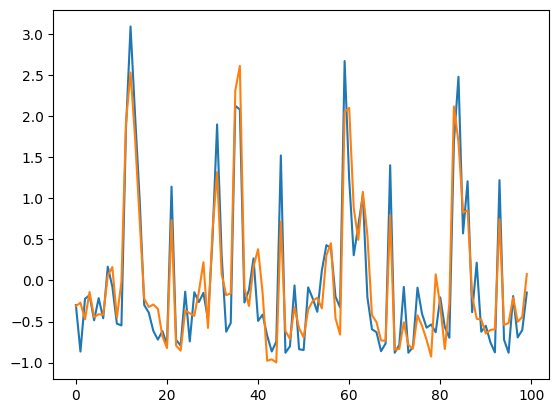

In [34]:
plt.plot(data.dataset[100:200,30])
plt.plot(synt[100:200,30])

0.007368821185082197

In [37]:
path = '/content/drive/MyDrive/hackathon/smart_meters_london_2013.csv'
df = pd.read_csv(path)

synthetic_data = synt*data.std + data.mean
synthetic_data = torch.cat([synthetic_data[:, :2660],torch.zeros(8760).unsqueeze(1), synthetic_data[:, 2660:]], dim=1)
synthetic_df = pd.DataFrame(synthetic_data.numpy())
synthetic_df['timestamp'] = df['timestamp']

synthetic_df.columns = synthetic_df.columns.astype(str)
synthetic_df = synthetic_df[df.columns.tolist()]

for column in synthetic_df.columns:
    if column != 'timestamp':
        synthetic_df.loc[synthetic_df[column] < 0, column] = torch.abs(torch.randn(1)*0.01).item()

In [38]:
synthetic_df

,timestamp,0,1,2,3,4,5,6,7,8,...,4115,4116,4117,4118,4119,4120,4121,4122,4123,4124
0,2013-01-01 00:00:00,0.888460,2.773849,0.183042,0.066841,0.041294,0.184741,0.770755,0.490670,0.037049,...,0.679004,0.292809,0.861155,0.098551,0.179919,0.264173,0.114616,0.289946,0.144581,0.407537
1,2013-01-01 01:00:00,0.386914,2.706103,0.083841,0.077131,0.072445,0.265163,0.848503,0.526165,0.083658,...,0.523787,0.013389,1.063226,0.286696,0.213093,0.217456,0.118360,0.295148,0.701523,0.213698
2,2013-01-01 02:00:00,0.327810,2.843621,0.079837,0.029039,0.042866,0.236174,0.665835,0.360070,0.038512,...,0.374771,0.082475,1.013909,0.320644,0.231786,0.231546,0.064788,0.232797,0.458430,0.151636
3,2013-01-01 03:00:00,0.223161,2.780645,0.079210,0.061788,0.040287,0.168862,0.560311,0.395299,0.018147,...,0.193643,0.123295,1.013771,0.282049,0.189605,0.218318,0.086848,0.171362,0.314023,0.085915
4,2013-01-01 04:00:00,0.256454,2.781071,0.079528,0.061943,0.043948,0.188710,0.503184,0.417858,0.027792,...,0.195852,0.091830,1.012884,0.239706,0.167045,0.196151,0.076331,0.148800,0.333719,0.068120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2013-12-31 19:00:00,0.978980,0.218969,0.008483,0.080934,0.245177,0.933768,3.390020,0.828470,0.006750,...,1.268614,1.204635,1.806801,0.282967,0.486738,0.311640,1.086228,0.966733,0.384834,0.229300
8756,2013-12-31 20:00:00,1.200791,0.470572,0.021190,0.006430,0.201347,0.984872,2.744013,1.116124,0.006750,...,0.998640,1.157619,1.930780,0.085204,0.160649,0.224340,0.546112,0.906826,0.177772,0.400539
8757,2013-12-31 21:00:00,0.841017,0.193667,0.103920,0.015222,0.196766,0.919479,1.989012,0.900870,0.112188,...,0.748551,1.101011,1.595949,0.061693,0.016614,0.207640,0.534866,0.967977,0.040668,0.312085
8758,2013-12-31 22:00:00,0.804458,0.003352,0.128307,0.045529,0.152211,0.881353,1.827728,0.899761,0.023831,...,0.494717,0.685113,0.855188,0.224184,0.078041,0.195871,0.417026,1.071148,0.156416,0.264644


In [39]:
synthetic_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,4115,4116,4117,4118,4119,4120,4121,4122,4123,4124
count,8760.000000,8760.000000,8.760000e+03,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,...,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,0.483738,0.818772,6.956489e-02,0.199219,0.123666,0.380016,1.071869,0.579175,0.088819,0.204856,...,0.468734,0.385521,1.439099,0.268564,0.249808,0.262819,0.299840,0.459005,0.912951,0.206672
std,0.383736,1.180596,4.254447e-02,0.179798,0.075914,0.366990,0.655680,0.398651,0.135041,0.090570,...,0.336937,0.350585,0.867544,0.200209,0.152994,0.148495,0.264909,0.285687,0.719527,0.177363
min,0.000666,0.000027,4.395843e-07,0.000143,0.000184,0.000138,0.002438,0.000268,0.000041,0.017421,...,0.000041,0.000079,0.000566,0.000052,0.001168,0.000232,0.000623,0.000299,0.000286,0.000164
25%,0.239993,0.244927,4.648120e-02,0.081978,0.069712,0.135461,0.553195,0.296779,0.023218,0.138578,...,0.230389,0.126882,0.746045,0.135377,0.166262,0.171042,0.132470,0.246368,0.292621,0.090409
50%,0.382153,0.451677,6.642487e-02,0.147360,0.109456,0.280977,0.935017,0.474537,0.050880,0.185239,...,0.380025,0.273350,1.266806,0.215623,0.210349,0.226950,0.209647,0.401185,0.749461,0.152382
75%,0.600147,0.703074,8.779918e-02,0.269375,0.164429,0.519740,1.413369,0.767662,0.087149,0.245970,...,0.641579,0.555465,1.958714,0.345444,0.282137,0.310684,0.363643,0.623261,1.406076,0.274221
max,3.658539,6.591375,1.126510e+00,2.462827,0.747906,5.697683,5.558445,3.134733,1.781526,0.780184,...,3.243612,3.172418,5.635882,1.835230,2.428486,1.550646,2.471600,2.272027,3.859579,1.964169


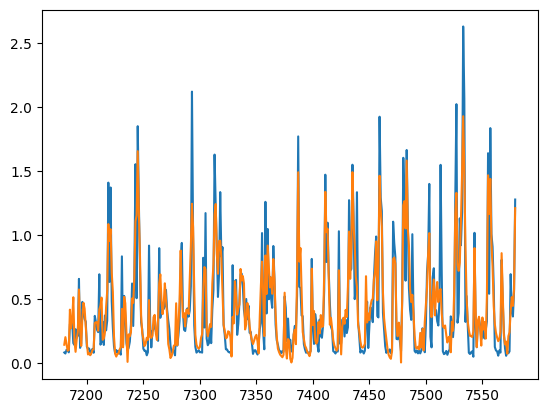

In [40]:
person_num = random.randint(0, 4124)
person_num = str(person_num)

range_1 = random.randint(0,8360)

plt.plot(df[person_num][range_1:range_1+400])
plt.plot(synthetic_df[person_num][range_1:range_1+400])

In [41]:
synthetic_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,4115,4116,4117,4118,4119,4120,4121,4122,4123,4124
count,8760.000000,8760.000000,8.760000e+03,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,...,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,0.483738,0.818772,6.956489e-02,0.199219,0.123666,0.380016,1.071869,0.579175,0.088819,0.204856,...,0.468734,0.385521,1.439099,0.268564,0.249808,0.262819,0.299840,0.459005,0.912951,0.206672
std,0.383736,1.180596,4.254447e-02,0.179798,0.075914,0.366990,0.655680,0.398651,0.135041,0.090570,...,0.336937,0.350585,0.867544,0.200209,0.152994,0.148495,0.264909,0.285687,0.719527,0.177363
min,0.000666,0.000027,4.395843e-07,0.000143,0.000184,0.000138,0.002438,0.000268,0.000041,0.017421,...,0.000041,0.000079,0.000566,0.000052,0.001168,0.000232,0.000623,0.000299,0.000286,0.000164
25%,0.239993,0.244927,4.648120e-02,0.081978,0.069712,0.135461,0.553195,0.296779,0.023218,0.138578,...,0.230389,0.126882,0.746045,0.135377,0.166262,0.171042,0.132470,0.246368,0.292621,0.090409
50%,0.382153,0.451677,6.642487e-02,0.147360,0.109456,0.280977,0.935017,0.474537,0.050880,0.185239,...,0.380025,0.273350,1.266806,0.215623,0.210349,0.226950,0.209647,0.401185,0.749461,0.152382
75%,0.600147,0.703074,8.779918e-02,0.269375,0.164429,0.519740,1.413369,0.767662,0.087149,0.245970,...,0.641579,0.555465,1.958714,0.345444,0.282137,0.310684,0.363643,0.623261,1.406076,0.274221
max,3.658539,6.591375,1.126510e+00,2.462827,0.747906,5.697683,5.558445,3.134733,1.781526,0.780184,...,3.243612,3.172418,5.635882,1.835230,2.428486,1.550646,2.471600,2.272027,3.859579,1.964169


In [42]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,4115,4116,4117,4118,4119,4120,4121,4122,4123,4124
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,...,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,0.481438,0.800525,0.070648,0.189043,0.120406,0.390757,1.063654,0.599210,0.092279,0.202296,...,0.457765,0.377104,1.418233,0.265388,0.249282,0.263274,0.306535,0.461277,0.871885,0.217083
std,0.430600,1.257639,0.092989,0.213302,0.091976,0.408338,0.750311,0.452462,0.153224,0.102091,...,0.385585,0.399897,0.933352,0.234450,0.185271,0.196039,0.289136,0.329330,0.766049,0.210138
min,0.170000,0.014000,0.000000,0.020000,0.000000,0.035000,0.234000,0.116000,0.000000,0.047000,...,0.089000,0.000000,0.297000,0.048000,0.111000,0.127000,0.080000,0.036000,0.115000,0.066000
25%,0.218000,0.216000,0.000000,0.065000,0.064000,0.150000,0.478000,0.267000,0.018000,0.125000,...,0.211000,0.109000,0.653000,0.129000,0.163000,0.166000,0.132000,0.252000,0.221000,0.098000
50%,0.324000,0.371000,0.000000,0.091000,0.100000,0.245500,0.836500,0.459000,0.060000,0.186000,...,0.303000,0.233000,1.189500,0.188000,0.194000,0.210000,0.196000,0.383000,0.563000,0.126000
75%,0.560000,0.545250,0.170000,0.235000,0.158000,0.465250,1.407000,0.769000,0.100000,0.254000,...,0.587000,0.496000,1.972250,0.311000,0.252000,0.276000,0.337000,0.595000,1.317000,0.270000
max,4.586000,7.241000,1.223000,3.119000,1.194000,6.739000,5.806000,3.984000,2.260000,0.835000,...,3.993000,4.292000,6.441000,2.504000,2.845000,1.962000,3.335000,2.818000,6.266000,2.242000


In [43]:
save_path = '/content/drive/MyDrive/hackathon/synthetic_data.csv'
synthetic_df.to_csv(save_path)